# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [ ]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

!unzip -q data.zip

--2023-12-04 08:52:36--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2023-12-04 08:52:36--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.06s   

2023-12-04 08:52:37 (276 MB/s) - ‘data.zip’ saved [17592727/17592727]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
!pip3 install pytorch_lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 15.4 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.functional import accuracy
from torch.optim.lr_scheduler import ExponentialLR

import random
import os

def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        names = ['xmin', 'ymin', 'xmax', 'ymax']
        coords = [int(member.find('bndbox/' + name).text) for name in names]
        class_id = class_dict[member.find('name').text]
        res =  coords + [class_id]

        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [ ]:
from matplotlib import patches

def visualize(images, bboxes):
    mean = torch.tensor((0.485, 0.456, 0.406))
    std = torch.tensor((0.229, 0.224, 0.225))

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv
        image = images[i] * std[:, None, None] + mean[:, None, None]
        ax.imshow(image.permute(1,2,0))

        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, class_ind = bbox
            width = xmax - xmin
            height = ymax - ymin

            ax.add_patch(
                patches.Rectangle(
                    (xmin, ymin),
                    width,
                    height,
                    color='red',
                    fill=False      # remove background
                )
            )
            ax.text(
                xmin, ymin,
                train_ds.class_dict_inv[class_ind],
                color='red'
            )

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

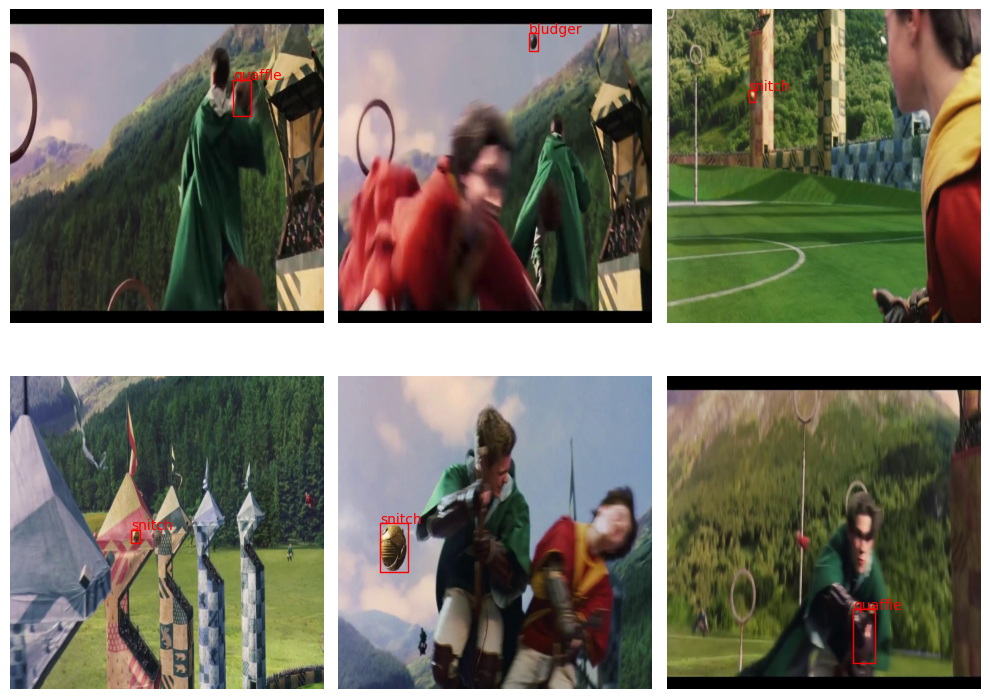

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO

Сейчас нам предстоить реализовать YOLO детектор. Это один из самых простых детекторов с точки зрения реализации. Он описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Мы будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16. В каждом пикселе мы будем предсказывать размеры прямоугольника и класс.



We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности. В каналах у нас будут записаны координаты центра, центр относительно координат пикселя, бинарная переменная (детекция присутствует), класс детекции.

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        w_box =  (xmax - xmin) / w
        h_box =  (ymax - ymin) / h

        # Посчитайте координаты центра и сдвиги
        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2
        cx_idx =  cx // downsample
        cy_idx =  cy // downsample

        cx_box =  (cx - cx_idx * downsample) / downsample
        cy_box =  (cy - cy_idx * downsample) / downsample

        cy_idx = cy_idx.type(torch.int).tolist()
        cx_idx = cx_idx.type(torch.int).tolist()

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

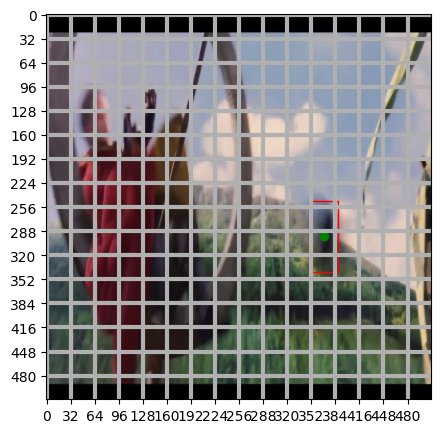

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Реализуйте аналогичные принципы, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами.

То есть, нужно проделать операции из collate_fn в обратную сторону.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample

    actual_bboxes = []

    for i, modified_bboxes in enumerate(pred):
        actual_bboxes.append([])
        for cy_idx in range(modified_bboxes.shape[1]):
            for cx_idx in range(modified_bboxes.shape[2]):
                cx_box, cy_box, w_box, h_box, is_detected, classes = modified_bboxes[:, cy_idx, cx_idx]
                classes = int(classes)

                if is_detected <= threshold:
                    continue

                cx = (cx_box + cx_idx) * upsample
                cy = (cy_box + cy_idx) * upsample

                width = img_w * w_box
                height = img_h * h_box

                xmin, ymin, xmax, ymax = cx - width / 2, cy - height / 2, cx + width / 2, cy + height / 2
                actual_bboxes[i].append((xmin, ymin, xmax, ymax, classes))

    return actual_bboxes

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 вклюяительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [ ]:
C = len(train_ds.class_dict_inv)


class Detector(nn.Module):
    def __init__(self):
        super().__init__()

        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet_layers = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        )
        self.layer1 = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1)
        )
        self.fc = nn.Sigmoid()

    def forward(self, img):
        return self.fc(self.layer1(self.resnet_layers(img)))

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)

* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [ ]:
# https://www.kaggle.com/code/zymzym/yolo-v1-loss
# https://arxiv.org/pdf/1506.02640.pdf
# помогло для понимания


def special_loss(pred, target, batch_size=10, check=False, C=C):
    mse = nn.MSELoss(reduction="sum")
    cross_entropy = nn.CrossEntropyLoss(reduction="sum")
    bce_loss = nn.BCELoss(reduction="sum")

    # складываем всевозможные объекты grid в словари
    pred_dict = {
        'cx': pred[:, 0, :, :].flatten(), 'cy': pred[:, 1, :, :].flatten(),
        'w': pred[:, 2, :, :].flatten(), 'h': pred[:, 3, :, :].flatten(),
        'confidence': pred[:, 4, :, :].flatten(), 'class': torch.reshape(pred[:, 5:, :, :], (batch_size * 16 * 16, 3))
    }
    target_dict = {
        'cx': target[:, 0, :, :].flatten(), 'cy': target[:, 1, :, :].flatten(),
        'w': target[:, 2, :, :].flatten(), 'h': target[:, 3, :, :].flatten(),
        'confidence': target[:, 4, :, :].flatten(), 'class': target[:, 5, :, :].flatten().long()
    }
    is_detected = target_dict['confidence'] == 1        # есть объект
    non_detected = ~is_detected                         # нет объекта

    pred_coords = torch.hstack((pred_dict['cx'][is_detected], pred_dict['cy'][is_detected]))
    target_coords = torch.hstack((target_dict['cx'][is_detected], target_dict['cy'][is_detected]))
    localization_loss = mse(pred_coords, target_coords)

    pred_dims = torch.hstack((torch.sqrt(pred_dict['w'][is_detected]), torch.sqrt(pred_dict['h'][is_detected])))
    target_dims = torch.hstack((torch.sqrt(target_dict['w'][is_detected]), torch.sqrt(target_dict['h'][is_detected])))
    box_loss = mse(pred_dims, target_dims)

    classification_loss = cross_entropy(pred_dict['class'][is_detected], target_dict['class'][is_detected])

    confidence_loss = bce_loss(pred_dict['confidence'][is_detected], target_dict['confidence'][is_detected])
    confidence_loss += 0.1 * bce_loss(pred_dict['confidence'][non_detected], target_dict['confidence'][non_detected])

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn, num_workers=2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  20
# Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        batch_size = batch['target'].shape[0]
        predictions = model(batch['image'].to(device))

        batch_loss = special_loss(predictions, batch['target'].to(device), batch_size=batch_size)
        epoch_losses.append(batch_loss.detach().cpu().numpy())
        batch_loss.backward()

        opt.step()
        opt.zero_grad()


    print(f"Epoch {e} done; Train loss {np.mean(np.array(epoch_losses)):.3f};")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 done; Train loss 91.982;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 31.255;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 22.653;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 19.252;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 17.113;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 14.940;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 14.102;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 12.886;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 9.944;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 8.126;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 7.554;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 7.470;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 7.193;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 7.110;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 6.556;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 6.397;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 6.330;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 6.357;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 6.304;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 6.281;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu

pred = model(batch['image'].to(device)).detach().cpu()
prediction = torch.zeros((6, 6, 16, 16))
prediction[:, :5, :, :] = pred[:, :5, :, :]
prediction[:, 5, :, :] = torch.argmax(pred[:, 5:, :, :], dim=1).type(torch.int)

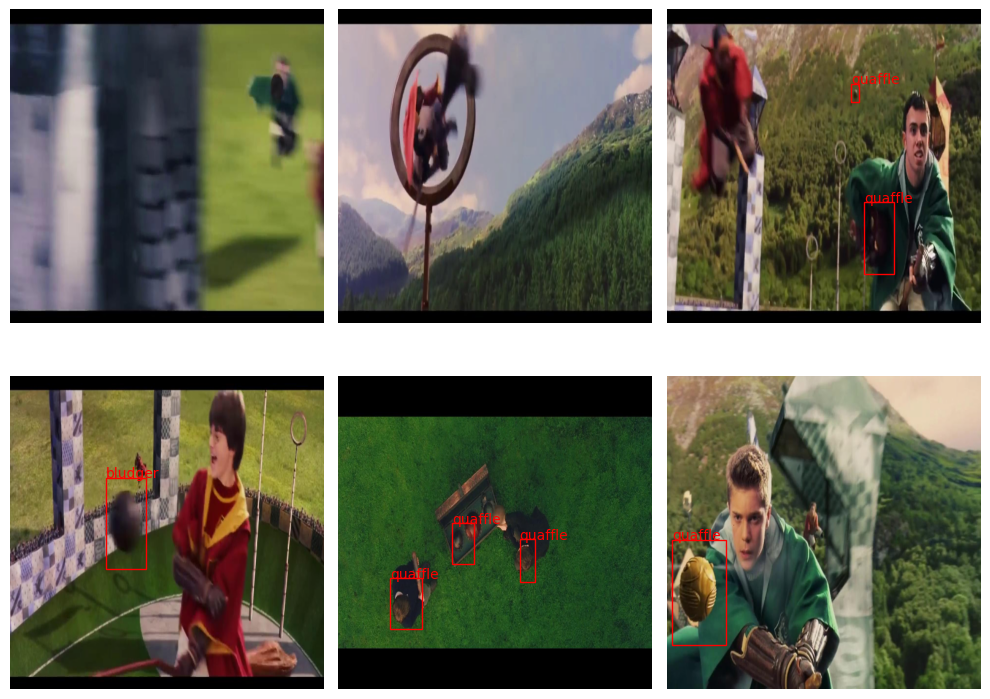

In [ ]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

decoded = decode_prediction(prediction, threshold=0.7)
visualize([o for o in batch["image"]], decoded)

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 10.1 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    yolo_strings = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax, class_ind = bbox
        width = (xmax - xmin) / w_im
        height = (ymax - ymin) / h_im
        cx = (xmin + xmax) / 2 / w_im
        cy = (ymin + ymax) / 2 / h_im

        string_info = list(map(str, [class_ind, cx, cy, width, height]))
        yolo_strings.append(' '.join(string_info))

    return yolo_strings

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc = len(train_ds.class_dict)
names = list(train_ds.class_dict.keys())

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from YAML

# Train the model
results = model.train(data='data.yaml', epochs=100, imgsz=512)  # load dataset for training and validation


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 46.0MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 150MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<00:00, 916.77it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 619.76it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.55G      5.044      9.296      4.257         28        512: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]

                   all         29         33   0.000396     0.0278   0.000316   5.66e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.55G      4.826      7.875      4.149         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         29         33   0.000383     0.0278   0.000336   5.99e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.55G      4.298      7.486      3.918         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         29         33   0.000361     0.0278   0.000283   5.23e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.55G      3.939      6.654      3.552         26        512: 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         29         33   0.000386     0.0278   0.000322   6.01e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.55G       3.52      5.736       3.37         37        512: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         29         33   0.000427     0.0278   0.000386   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.55G      3.452      5.695      2.973         34        512: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         29         33   0.000385     0.0278    0.00101   0.000122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.55G      3.067      5.359      2.725         22        512: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         29         33   0.000329     0.0278   0.000285   2.85e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.55G       3.11      4.799      2.671         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         29         33   0.000629      0.103   0.000446   0.000141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.55G      2.955      4.635      2.499         29        512: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         29         33   0.000578     0.0992    0.00126   0.000338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.55G      2.847      4.566      2.462         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         29         33   0.000607      0.123    0.00463    0.00277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.55G      2.839        4.1      2.381         31        512: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         29         33      0.073     0.0476     0.0372     0.0225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.55G      2.749      4.014      2.228         20        512: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         29         33      0.133     0.0516     0.0489     0.0169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.55G      2.659      3.619       2.09         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         29         33      0.116     0.0714     0.0631      0.033



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.55G       2.67      3.511      2.182         28        512: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         29         33      0.876     0.0476     0.0552     0.0335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.55G      2.466      3.364      2.035         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         29         33      0.632     0.0476     0.0592      0.038



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.55G      2.489      3.382      2.043         31        512: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         29         33      0.187     0.0714     0.0707     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.55G      2.346      3.109      1.923         35        512: 100%|██████████| 16/16 [00:04<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         29         33      0.631     0.0476     0.0608     0.0429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.55G      2.335      3.047      1.885         44        512: 100%|██████████| 16/16 [00:03<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         29         33      0.651     0.0476     0.0754      0.045



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.55G      2.252      2.909      1.876         29        512: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         29         33      0.615     0.0476     0.0681     0.0441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.55G      2.233      2.907      1.732         38        512: 100%|██████████| 16/16 [00:04<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         29         33      0.452     0.0714     0.0779     0.0384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.55G      2.163      2.773      1.705         23        512: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         29         33      0.907     0.0714     0.0748     0.0446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.55G      2.104      2.594      1.692         30        512: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         33      0.568     0.0714     0.0888     0.0523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.55G      2.243      2.596      1.866         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         29         33      0.548     0.0714     0.0763     0.0439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.55G      2.097       2.48      1.641         27        512: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         29         33      0.092      0.143     0.0909     0.0548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.55G      2.073      2.469      1.696         23        512: 100%|██████████| 16/16 [00:04<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         29         33     0.0734      0.119     0.0832     0.0579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.55G      2.006      2.272      1.616         28        512: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         29         33      0.129     0.0904      0.113     0.0519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.55G      1.965      2.347      1.598         23        512: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         29         33     0.0967      0.119     0.0963     0.0498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.55G      1.871      2.183      1.542         30        512: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         29         33      0.136      0.171      0.126     0.0617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.55G      1.969      2.138      1.608         31        512: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         29         33        0.5     0.0952      0.119     0.0583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.55G      2.015      2.083      1.622         33        512: 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         29         33      0.983     0.0952      0.125     0.0564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.55G      1.848      2.064      1.527         22        512: 100%|██████████| 16/16 [00:04<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         29         33      0.238      0.171      0.145     0.0644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.55G      1.964      2.084      1.523         41        512: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29         33      0.312     0.0992      0.113     0.0592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.55G      1.896      2.089      1.537         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         29         33      0.362       0.12      0.132     0.0755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.55G      1.938       2.09      1.525         28        512: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         29         33      0.225      0.171      0.176     0.0917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.55G      1.875      1.926      1.505         35        512: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         29         33      0.151      0.179      0.136     0.0694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.55G      1.814      1.962      1.433         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         29         33      0.264      0.171      0.144     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.55G      1.827      1.879      1.477         32        512: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         29         33       0.24      0.147      0.162      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.55G      1.902      1.886      1.545         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         29         33       0.22      0.166      0.173     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.55G      1.812      1.816      1.492         27        512: 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         29         33      0.304      0.123       0.15     0.0685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.55G      1.792      1.864      1.461         30        512: 100%|██████████| 16/16 [00:04<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         29         33      0.195      0.194      0.149     0.0751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.55G      1.771      1.849      1.437         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         29         33      0.192      0.171      0.144      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.55G      1.907      1.825      1.551         31        512: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         33       0.21      0.121      0.109     0.0508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.55G      1.748       1.72      1.395         25        512: 100%|██████████| 16/16 [00:03<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         29         33      0.198      0.218      0.161     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.55G      1.714      1.596      1.341         31        512: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         29         33      0.259      0.212      0.182     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.55G      1.705      1.644      1.413         31        512: 100%|██████████| 16/16 [00:04<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         29         33      0.221      0.171       0.15     0.0829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.55G      1.711      1.732      1.388         38        512: 100%|██████████| 16/16 [00:03<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         29         33      0.604      0.218       0.18     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.55G      1.709      1.714       1.37         26        512: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         29         33      0.296      0.147      0.172      0.085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.55G      1.706      1.648      1.399         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         29         33      0.299      0.123      0.148     0.0734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.55G      1.764      1.677      1.353         23        512: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         29         33       0.27      0.194      0.193     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.55G      1.607      1.554      1.329         18        512: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         29         33       0.23      0.218      0.183      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.55G       1.72      1.624      1.412         30        512: 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         29         33      0.257      0.218      0.196     0.0974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.55G      1.755      1.645      1.404         29        512: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         29         33      0.231      0.171      0.169     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.55G      1.712      1.595      1.379         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         33      0.173      0.186      0.166     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.55G      1.639       1.48      1.402         25        512: 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         29         33       0.24      0.171       0.16     0.0877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.55G      1.594      1.385      1.368         32        512: 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         29         33      0.195      0.218      0.161     0.0872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.55G      1.664      1.484      1.335         27        512: 100%|██████████| 16/16 [00:04<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         29         33      0.219      0.194      0.175     0.0743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.55G      1.518      1.359      1.259         26        512: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         29         33      0.262      0.171      0.205     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.55G       1.59      1.457      1.267         30        512: 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         29         33      0.266      0.217      0.209     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.55G      1.543       1.35      1.274         24        512: 100%|██████████| 16/16 [00:04<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         29         33      0.242      0.216      0.187     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.55G      1.556      1.436      1.263         26        512: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         29         33      0.234      0.218      0.176     0.0873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.55G      1.527      1.292      1.253         27        512: 100%|██████████| 16/16 [00:04<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         29         33      0.246      0.218      0.176        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.55G      1.495      1.274       1.29         29        512: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         29         33      0.371      0.241      0.232      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.55G      1.556      1.388      1.285         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         29         33      0.325      0.242      0.234      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.55G      1.506      1.397      1.285         21        512: 100%|██████████| 16/16 [00:03<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         29         33      0.276      0.238      0.206      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.55G      1.577      1.412      1.366         32        512: 100%|██████████| 16/16 [00:05<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         29         33      0.654      0.242      0.224      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.55G      1.607      1.397      1.324         36        512: 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         29         33      0.276      0.194      0.214      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.55G      1.443      1.315      1.231         28        512: 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         29         33      0.382       0.17      0.216      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.55G      1.541      1.297      1.287         26        512: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         29         33      0.286      0.194      0.212      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.55G      1.551      1.357      1.327         29        512: 100%|██████████| 16/16 [00:04<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         29         33        0.3      0.218      0.224      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.55G      1.566      1.316      1.303         34        512: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         29         33      0.201      0.242       0.23       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.55G      1.545      1.298       1.35         26        512: 100%|██████████| 16/16 [00:04<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         29         33      0.279      0.242      0.213      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.55G      1.417      1.232      1.248         30        512: 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         29         33      0.232      0.194        0.2     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.55G      1.433      1.212      1.256         31        512: 100%|██████████| 16/16 [00:04<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         29         33      0.282      0.194      0.225      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.55G      1.341      1.117      1.193         32        512: 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         29         33      0.287      0.218      0.223     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.55G      1.405      1.217      1.201         24        512: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         29         33      0.325      0.218      0.236      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.55G      1.447      1.213      1.269         33        512: 100%|██████████| 16/16 [00:03<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         29         33      0.289      0.241      0.241      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.55G      1.448      1.167      1.231         24        512: 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         29         33      0.274       0.24      0.242      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.55G      1.464      1.199      1.256         22        512: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         29         33      0.276      0.242      0.244      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.55G      1.386      1.173      1.185         30        512: 100%|██████████| 16/16 [00:04<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         29         33      0.294      0.284      0.252      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.55G       1.41      1.137      1.206         31        512: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         29         33      0.333      0.237      0.259      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.55G      1.424      1.155      1.228         32        512: 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         29         33      0.279      0.242      0.254      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.55G      1.349      1.113      1.191         26        512: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         29         33      0.273      0.244      0.256       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.55G      1.426      1.193      1.292         29        512: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         29         33      0.274      0.275      0.258      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.55G      1.398      1.175      1.228         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         29         33      0.293      0.242      0.257       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.55G      1.366      1.111      1.195         33        512: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         29         33      0.293      0.266      0.256      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.55G      1.398      1.116      1.167         32        512: 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         29         33      0.315      0.266      0.251       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.55G      1.438      1.154      1.169         28        512: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         29         33      0.267      0.226      0.226      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.55G      1.396      1.112      1.206         28        512: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         29         33      0.299      0.207      0.227       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.55G      1.321      1.079      1.206         24        512: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         29         33      0.271      0.242      0.229      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.55G      1.357      1.106      1.172         29        512: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         29         33      0.274      0.236      0.227      0.112


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.55G      1.349      1.198      1.186         17        512: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         33      0.269      0.218       0.22      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.55G      1.375      1.139      1.205         16        512: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         29         33      0.239      0.194       0.17     0.0975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.55G      1.361      1.125      1.183         19        512: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         29         33      0.311      0.242      0.244      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.55G      1.331      1.092      1.217         15        512: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         29         33      0.326      0.231       0.25      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.55G      1.357      1.105      1.209         16        512: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29         33      0.291       0.28      0.253      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.55G      1.273      1.035      1.171         16        512: 100%|██████████| 16/16 [00:03<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         29         33      0.259      0.275      0.245      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.55G      1.332      1.062       1.18         15        512: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         29         33      0.226      0.259      0.213      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.55G      1.294      1.074       1.22         15        512: 100%|██████████| 16/16 [00:04<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         29         33       0.29      0.194      0.219      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.55G       1.28      1.048      1.183         15        512: 100%|██████████| 16/16 [00:03<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         29         33      0.298      0.223      0.244      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.55G      1.181     0.9624      1.127         16        512: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         29         33      0.317      0.218      0.242      0.104



100 epochs completed in 0.176 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


                   all         29         33      0.281      0.242      0.254      0.124
                snitch         29         14      0.773      0.643      0.731      0.363
               quaffle         29         12     0.0701     0.0833     0.0305    0.00976
               bludger         29          7          0          0          0          0
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

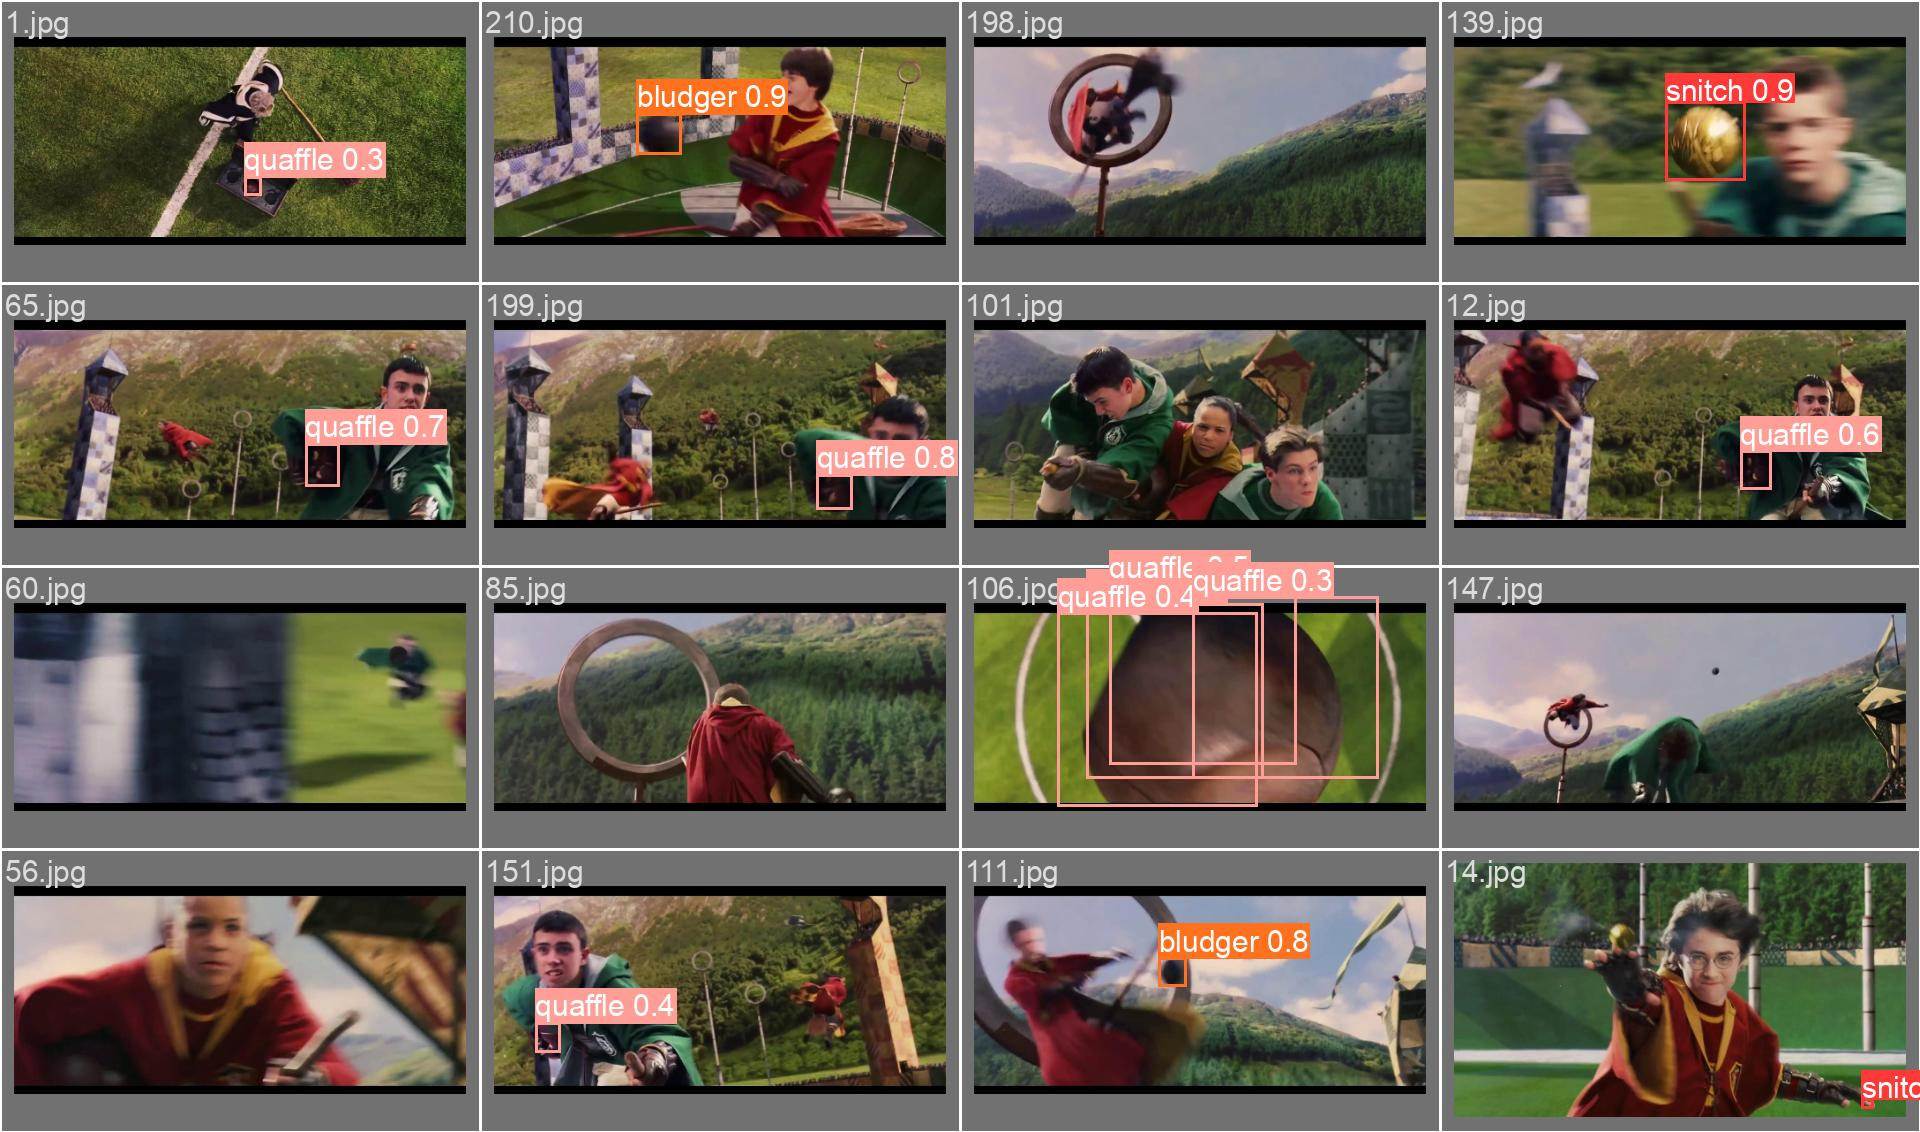

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread('/content/runs/detect/train/val_batch0_pred.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)